In [1]:
image_paths_TRAIN = {"aeroplane":"VOCdevkit/VOC2012/ImageSets/Main/aeroplane_train.txt","bird":"VOCdevkit/VOC2012/ImageSets/Main/bird_train.txt","person":"VOCdevkit/VOC2012/ImageSets/Main/person_train.txt","sofa":"VOCdevkit/VOC2012/ImageSets/Main/sofa_train.txt"}
image_paths_TEST = {"aeroplane":"VOCdevkit/VOC2012/ImageSets/Main/aeroplane_test.txt","bird":"VOCdevkit/VOC2012/ImageSets/Main/bird_test.txt","person":"VOCdevkit/VOC2012/ImageSets/Main/person_test.txt","sofa":"VOCdevkit/VOC2012/ImageSets/Main/sofa_test.txt"}
classes = ["person","bird","aeroplane","sofa"]

Before we do anything first we should create a dataset with a reference of our patches of images where we have objects we are interested in recognizing.

In [2]:
import pandas as pd

In [3]:
cols= ["file","obj_id","class","xmax","xmin","ymax","ymin"]
image_dataset = pd.DataFrame(columns=cols)
image_dataset

Empty DataFrame
Columns: [file, obj_id, class, xmax, xmin, ymax, ymin]
Index: []

Get all files in folder, so all available images in the dataset:

In [4]:
import glob
list_of_files = glob.glob("VOCdevkit/VOC2012/Annotations/*.xml")

In [5]:
from bs4 import BeautifulSoup
#import lxml

In [6]:
len_files = len(list_of_files)
for progr_cnt , file in enumerate(list_of_files):
    print(f"{file}  :::  {progr_cnt}/{len_files}")
    with open(file, 'r') as f:
        data = f.read()
    
    #first fast check to see if the file contains anything of the classes we want to detect
    interest = False
    for clas in classes:
        if clas in data:
            interest = True
    if interest == False:
        pass #do not continue with further processing skip to next image xml
    
    #We will interpret the xml using beautiful soup
    Bs_data = BeautifulSoup(data, "lxml")
    objects = Bs_data.find_all('object')
    for obj_cnt,obj in enumerate(objects):
        name = obj.find('name').contents[0]
        if name in classes:
            #we first convert to float to avoid some edge cases in some files such as:
            # <ymin>45.70000076293945</ymin> in 2011_003353.xml
            box = {"xmax":int(obj.find('xmax').contents[0]),
            "xmin":int(float(obj.find('xmin').contents[0])),
            "ymax":int(float(obj.find('ymax').contents[0])),
            "ymin":int(float(obj.find('ymin').contents[0]))}
            #we'll use the box variable to pack together all the data we want to append to the image dataset
            box["class"] = name
            box["obj_id"] = obj_cnt
            box["file"] = file[30:-4]
            image_dataset.loc[len(image_dataset)] = box
            

VOCdevkit/VOC2012/Annotations/2011_006135.xml  :::  0/17125
VOCdevkit/VOC2012/Annotations/2008_006482.xml  :::  1/17125
VOCdevkit/VOC2012/Annotations/2010_005054.xml  :::  2/17125
VOCdevkit/VOC2012/Annotations/2010_005732.xml  :::  3/17125
VOCdevkit/VOC2012/Annotations/2011_004044.xml  :::  4/17125
VOCdevkit/VOC2012/Annotations/2010_003343.xml  :::  5/17125
VOCdevkit/VOC2012/Annotations/2011_002435.xml  :::  6/17125
VOCdevkit/VOC2012/Annotations/2008_000795.xml  :::  7/17125
VOCdevkit/VOC2012/Annotations/2012_000947.xml  :::  8/17125
VOCdevkit/VOC2012/Annotations/2012_002188.xml  :::  9/17125
VOCdevkit/VOC2012/Annotations/2011_000222.xml  :::  10/17125
VOCdevkit/VOC2012/Annotations/2008_002182.xml  :::  11/17125
VOCdevkit/VOC2012/Annotations/2008_005821.xml  :::  12/17125
VOCdevkit/VOC2012/Annotations/2008_003288.xml  :::  13/17125
VOCdevkit/VOC2012/Annotations/2007_002120.xml  :::  14/17125
VOCdevkit/VOC2012/Annotations/2009_003838.xml  :::  15/17125
VOCdevkit/VOC2012/Annotations/2011

In [7]:
image_dataset.head()

file  obj_id   class  xmax  xmin  ymax  ymin
0  2011_006135       0  person   470   391   315   144
1  2010_005054       1    sofa   427   318   111    42
2  2010_005054       2    sofa    98     1   111    70
3  2011_004044       0  person   337   220   375   143
4  2011_004044       1  person   214   102   375   187

Looks pretty nice, we'll save this to a csv file so we don't have to calculate this again:

In [8]:
image_dataset.to_csv("image_dataset.csv",index=False)

# Processing the images:

In [9]:
image_paths_TRAIN = {"aeroplane":"VOCdevkit/VOC2012/ImageSets/Main/aeroplane_train.txt","bird":"VOCdevkit/VOC2012/ImageSets/Main/bird_train.txt","person":"VOCdevkit/VOC2012/ImageSets/Main/person_train.txt","sofa":"VOCdevkit/VOC2012/ImageSets/Main/sofa_train.txt"}
image_paths_TEST = {"aeroplane":"VOCdevkit/VOC2012/ImageSets/Main/aeroplane_test.txt","bird":"VOCdevkit/VOC2012/ImageSets/Main/bird_test.txt","person":"VOCdevkit/VOC2012/ImageSets/Main/person_test.txt","sofa":"VOCdevkit/VOC2012/ImageSets/Main/sofa_test.txt"}
classes = ["person","bird","aeroplane","sofa"]

In [10]:
import pandas as pd

In [11]:
image_dataset = pd.read_csv("image_dataset.csv")

In [12]:
import cv2
from matplotlib import pyplot as plt

In [13]:
im_folder = "VOCdevkit/VOC2012/JPEGImages/"

First of all we'll visualize some images to check if the xml data was correct and we did the above process right

In [14]:
image_dataset

file  obj_id   class  xmax  xmin  ymax  ymin
0      2011_006135       0  person   470   391   315   144
1      2010_005054       1    sofa   427   318   111    42
2      2010_005054       2    sofa    98     1   111    70
3      2011_004044       0  person   337   220   375   143
4      2011_004044       1  person   214   102   375   187
...            ...     ...     ...   ...   ...   ...   ...
20510  2011_003054       6  person   473   462   273   246
20511  2010_002722       0  person    67    31   259   178
20512  2010_002722       1  person   103    73   253   171
20513  2007_005124       1  person   271     3   324    33
20514  2010_006544       0  person   445   217   318    43

[20515 rows x 7 columns]

person


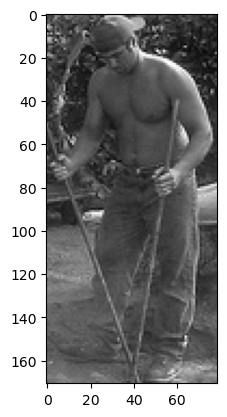

sofa


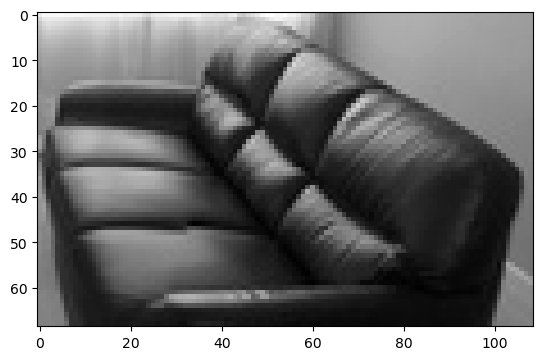

sofa


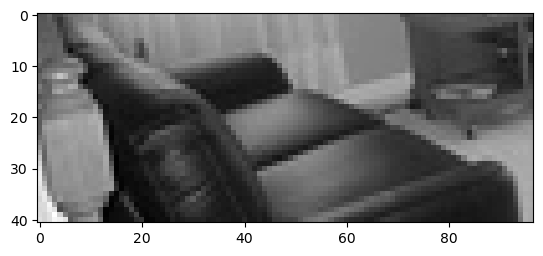

person


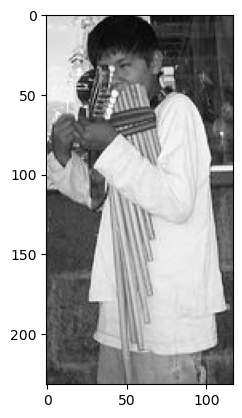

person


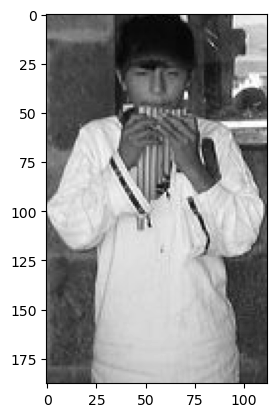

sofa


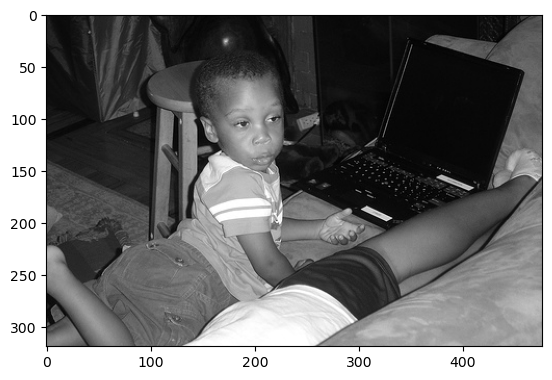

person


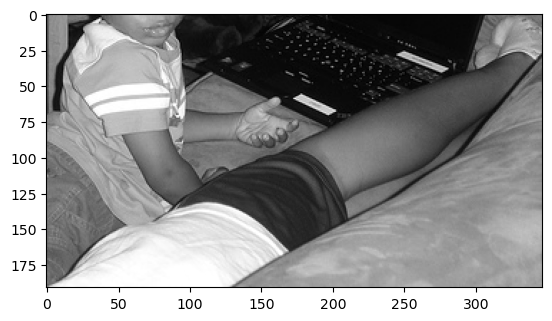

person


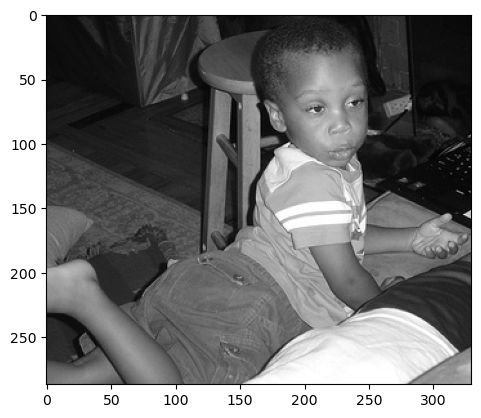

person


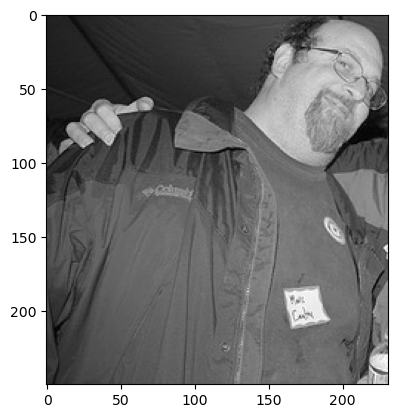

person


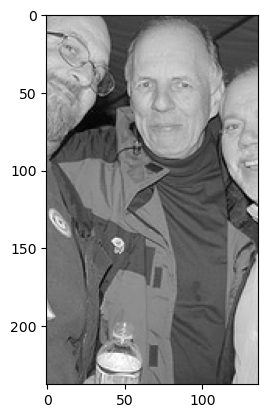

person


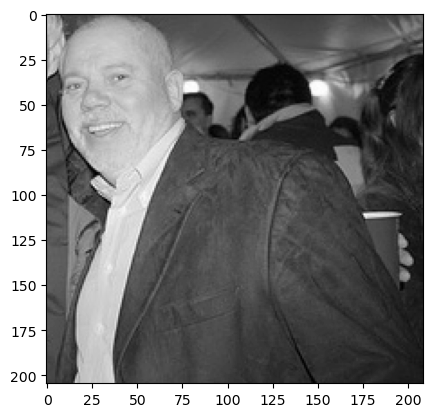

In [15]:
cnt = 0
for idx, row in image_dataset.iterrows():
    image = cv2.imread(im_folder+row["file"]+".jpg") #read image
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) #convert to grayscale
    image = image[row["ymin"]:row["ymax"],row["xmin"]:row["xmax"]]
    print(row["class"])
    plt.imshow(image,cmap="gray")
    plt.show()
    cnt +=1
    if(cnt > 10):
        break
    

Out of these extracted crops we don't know if classes are properly balanced. We should take a look at it:

In [16]:
image_dataset["class"].value_counts()

person       17401
bird          1271
aeroplane     1002
sofa           841
Name: class, dtype: int64

It us unreasonably unbalanced, if we trained a model with these proportions we would get a big bias towards person. We need to take out some person images

In [17]:
import numpy as np

We'll remove 16300 rows of person class so we have around 1100 person images

In [18]:
np.random.seed(10) #so it is replicable every time
drop_indices = np.random.choice(image_dataset[image_dataset["class"]=="person"].index,16300,replace = False)
image_dataset = image_dataset.drop(drop_indices)

Check:

In [19]:
image_dataset["class"].value_counts()

bird         1271
person       1101
aeroplane    1002
sofa          841
Name: class, dtype: int64

In [20]:
image_dataset = image_dataset.reset_index()

In [21]:
image_dataset

index         file  obj_id   class  xmax  xmin  ymax  ymin
0         1  2010_005054       1    sofa   427   318   111    42
1         2  2010_005054       2    sofa    98     1   111    70
2         5  2011_002435       0    sofa   500    23   375    56
3        16  2011_000222       0    bird   343   145   366    61
4        17  2008_005821       0    bird   438     1   333     1
...     ...          ...     ...     ...   ...   ...   ...   ...
4210  20475  2008_000798       1    bird   196   125   262   186
4211  20476  2008_000798       2    bird   130    53   237   156
4212  20485  2008_003291       0    bird   394    65   417    78
4213  20491  2009_003835       3    sofa   347   178   278   178
4214  20506  2011_003054       2  person   335   311   312   244

[4215 rows x 8 columns]

We see that we have some noise in our data but it is good enough.
We'll proceed by extracting the sift features from each image patch

In [22]:
#Ths is the sift object we are going to use to process our images,
#Note that we maxed out the number of features per image to 100 
#to not have too many data and for the sake of processing in a reasonable amount of time
sift = cv2.SIFT_create(nfeatures=40) #sift detector object

First, some testing:

sofa


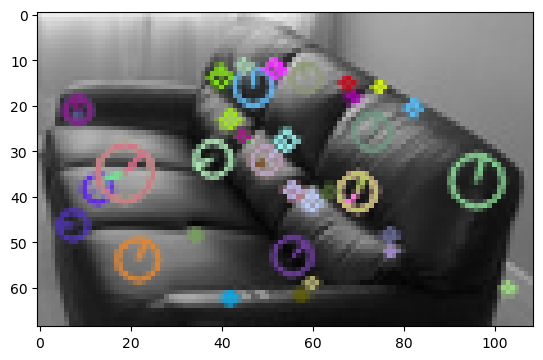

sofa


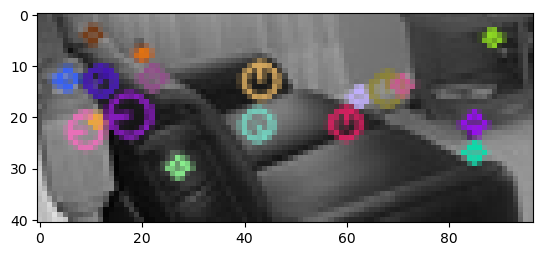

sofa


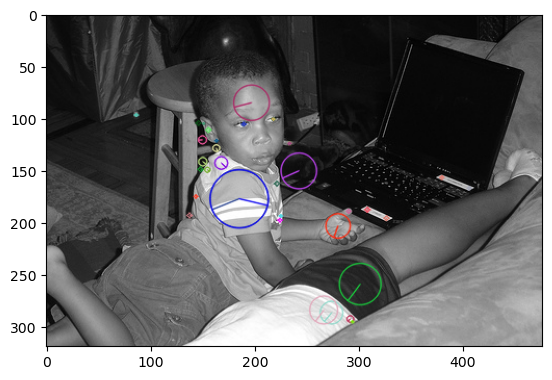

bird


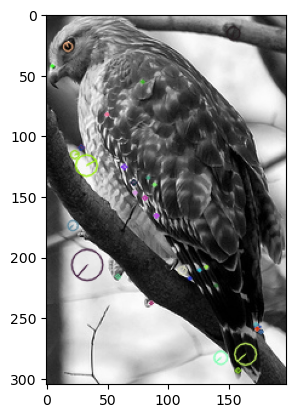

bird


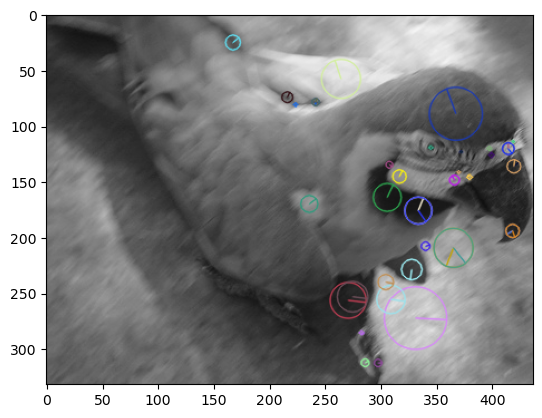

bird


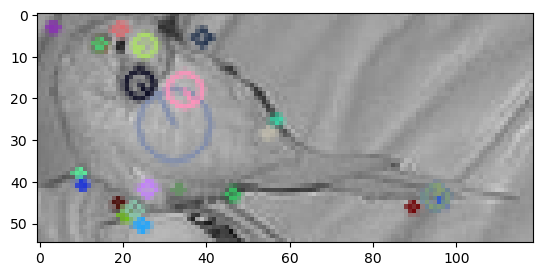

bird


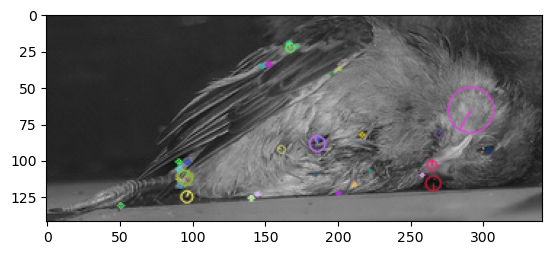

bird


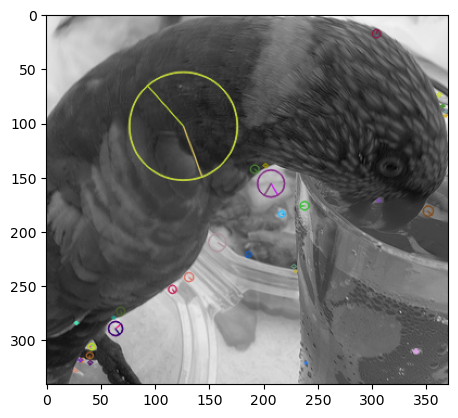

sofa


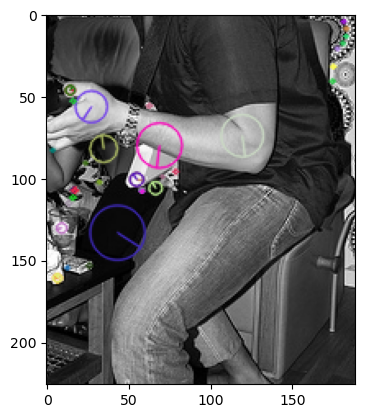

sofa


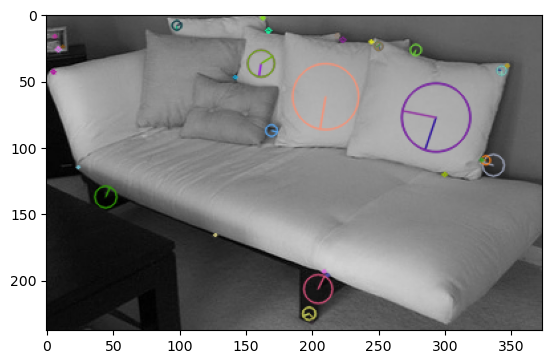

bird


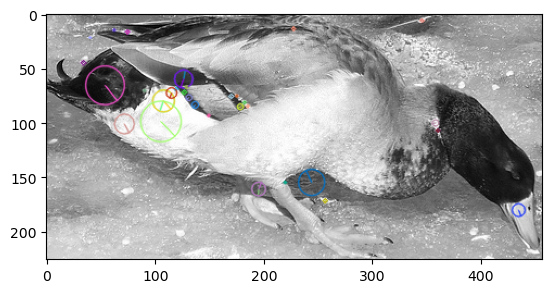

In [23]:
cnt = 0
for idx, row in image_dataset.iterrows():
    image = cv2.imread(im_folder+row["file"]+".jpg") #read image
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) #convert to grayscale
    image = image[row["ymin"]:row["ymax"],row["xmin"]:row["xmax"]]
    kp, des = sift.detectAndCompute(image,None)
    img=cv2.drawKeypoints(image ,
                kp ,
                image ,
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    print(row["class"])
    plt.imshow(img,cmap="gray")
    plt.show()
    cnt +=1
    if(cnt > 10):
        break
    

Processing all images:

In [24]:
#some other libraries we are gonna need:
import numpy as np

Note : In this process we are only going to keep the descriptor part of the interest points as their position in the image is irrelevant to us:

TEST:

2008_002356
None


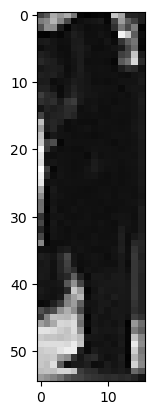

2008_006873
None


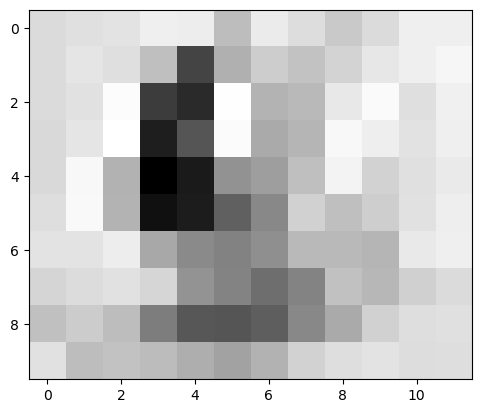

2008_006873
None


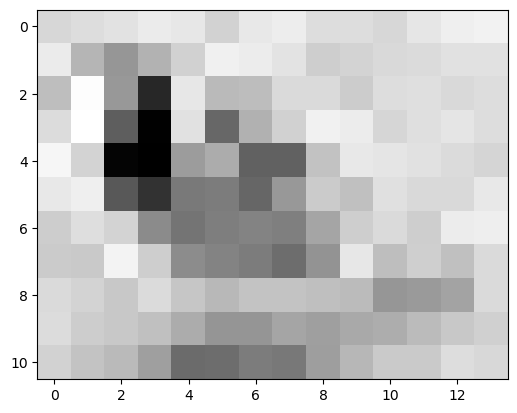

2008_005599
None


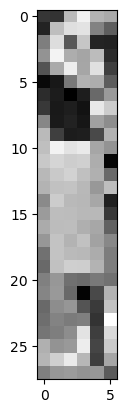

2011_001476
None


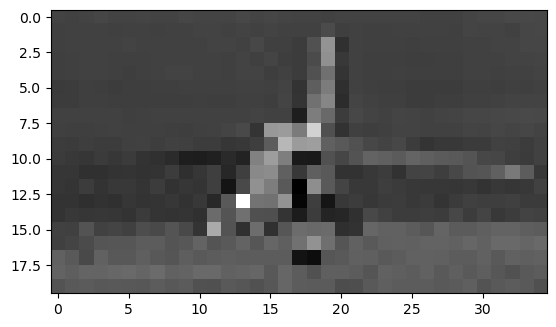

2011_001476
None


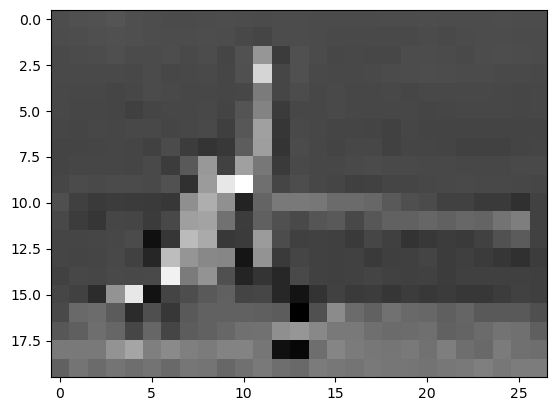

In [25]:
WORDS_des = {"person":np.empty([0,128]),"bird":np.empty([0,128]),"aeroplane":np.empty([0,128]),"sofa":np.empty([0,128])} #Where we will store all our descriptor vectors from all images
WORDS_kcen = np.empty((0,128)) #The found words o kmeans cluster centers

cnt = 0
for idx, row in image_dataset.iterrows():
    image = cv2.imread(im_folder+row["file"]+".jpg") #read image
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) #convert to grayscale
    image = image[row["ymin"]:row["ymax"],row["xmin"]:row["xmax"]]
    kp, des = sift.detectAndCompute(image,None)
    try:
        np.append(WORDS_des[row["class"]],np.matrix(des),axis=0)
    except:
        print(row["file"])
        print(des)
        plt.imshow(image,cmap="gray")
        plt.show()
        cnt += 1
    
    if cnt > 5:
        break


Some images do not output any sift interest points and seem very pixelated, we will pick them out of the dataset.

In [26]:

#128 is the size of the sift descriptor vectors
WORDS_des = {"person":np.empty([0,128]),"bird":np.empty([0,128]),"aeroplane":np.empty([0,128]),"sofa":np.empty([0,128])} #Where we will store all our descriptor vectors from all images

new_img_dataset = image_dataset.copy()
cnt = 0
total_im = len(image_dataset)
for idx, row in image_dataset.iterrows():
    image = cv2.imread(im_folder+row["file"]+".jpg") #read image
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) #convert to grayscale
    image = image[row["ymin"]:row["ymax"],row["xmin"]:row["xmax"]]
    kp, des = sift.detectAndCompute(image,None)
    try:
        WORDS_des[row["class"]] = np.append(WORDS_des[row["class"]],np.matrix(des),axis=0)
    except:
        new_img_dataset = new_img_dataset[new_img_dataset.file != row["file"]]
    
    cnt += 1
    print(f"{cnt}/{total_im}")


1/4215
2/4215
3/4215
4/4215
5/4215
6/4215
7/4215
8/4215
9/4215
10/4215
11/4215
12/4215
13/4215
14/4215
15/4215
16/4215
17/4215
18/4215
19/4215
20/4215
21/4215
22/4215
23/4215
24/4215
25/4215
26/4215
27/4215
28/4215
29/4215
30/4215
31/4215
32/4215
33/4215
34/4215
35/4215
36/4215
37/4215
38/4215
39/4215
40/4215
41/4215
42/4215
43/4215
44/4215
45/4215
46/4215
47/4215
48/4215
49/4215
50/4215
51/4215
52/4215
53/4215
54/4215
55/4215
56/4215
57/4215
58/4215
59/4215
60/4215
61/4215
62/4215
63/4215
64/4215
65/4215
66/4215
67/4215
68/4215
69/4215
70/4215
71/4215
72/4215
73/4215
74/4215
75/4215
76/4215
77/4215
78/4215
79/4215
80/4215
81/4215
82/4215
83/4215
84/4215
85/4215
86/4215
87/4215
88/4215
89/4215
90/4215
91/4215
92/4215
93/4215
94/4215
95/4215
96/4215
97/4215
98/4215
99/4215
100/4215
101/4215
102/4215
103/4215
104/4215
105/4215
106/4215
107/4215
108/4215
109/4215
110/4215
111/4215
112/4215
113/4215
114/4215
115/4215
116/4215
117/4215
118/4215
119/4215
120/4215
121/4215
122/4215
123/4215
1

In [27]:
new_img_dataset.to_csv("clean_imgage_dataset.csv",index=False)

Now we have a matrix with sift descriptor vectors for each class and of a bunch of image patches.

For each class we'll apply kmeans and find the cluster centers, these should be the most common "words" and so the ones we should put in our dictionary

In [28]:
from sklearn.cluster import KMeans

In [29]:
K_CENTERS_WORDS_PER_CLASS = 10

In [30]:
WORDS_kcen = np.empty([0,128]) #all words from all clusters will end up here
for clss in classes:
    print(f"{clss} started")
    kmeans = KMeans(n_clusters=K_CENTERS_WORDS_PER_CLASS).fit(np.asarray(WORDS_des[clss])) 
    #save the kluster centers, our words.
    WORDS_kcen = np.append(WORDS_kcen,kmeans.cluster_centers_,axis=0)
    print(f"{clss} done.")

person started
person done.
bird started
bird done.
aeroplane started
aeroplane done.
sofa started
sofa done.


Save the calculated words to a file so we don't have to calculate them again

In [31]:
import pickle
output = open("words_kcen.pkl","wb")
pickle.dump(WORDS_kcen,output)
output.close()

output = open("words_des.pkl","wb")
pickle.dump(WORDS_des,output)
output.close()

# USING OUR DICTIONARY TO CLASSIFY IMAGES

In [32]:
import pickle
pkl_file = open("words_kcen.pkl", 'rb')
WORDS_kcen = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open("words_des.pkl", 'rb')
WORDS_des = pickle.load(pkl_file)
pkl_file.close()

Train a 1 Neighbor KNN to be able to classify vectors as one word or another

In [33]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [34]:
word_detect = KNeighborsClassifier(n_neighbors=1)
y = np.arange(len(WORDS_kcen))
word_detect.fit(WORDS_kcen,y)

KNeighborsClassifier(n_neighbors=1)

In [35]:
import pandas as pd
image_dataset = pd.read_csv("clean_imgage_dataset.csv")

feature_dataset = image_dataset[["file","obj_id","class"]]
feature_dataset

file  obj_id   class
0     2010_005054       1    sofa
1     2010_005054       2    sofa
2     2011_002435       0    sofa
3     2011_000222       0    bird
4     2008_005821       0    bird
...           ...     ...     ...
4032  2008_000798       1    bird
4033  2008_000798       2    bird
4034  2008_003291       0    bird
4035  2009_003835       3    sofa
4036  2011_003054       2  person

[4037 rows x 3 columns]

Now to compute the sift vectors we could reutilize the values stored in the WORDS_des variable, but just for the sake of evading errors we will compute everything again:

In [36]:
#128 is the size of the sift descriptor vectors
WORDS_des = {"person":np.empty([0,128]),"bird":np.empty([0,128]),"aeroplane":np.empty([0,128]),"sofa":np.empty([0,128])} #Where we will store all our descriptor vectors from all images

cnt = 0
total_im = len(image_dataset)
for idx, row in image_dataset.iterrows():
    cnt += 1
    print(f"{cnt}/{total_im}")

    image = cv2.imread(im_folder+row["file"]+".jpg") #read image
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) #convert to grayscale
    image = image[row["ymin"]:row["ymax"],row["xmin"]:row["xmax"]]
    kp, des = sift.detectAndCompute(image,None)
    try:
        WORDS_des[row["class"]] = np.append(WORDS_des[row["class"]],np.matrix(des),axis=0)
        pred = word_detect.predict(des)
        word_counts = dict(pd.Series(pred).value_counts())
        new_cols = list(dict(pd.Series(pred).value_counts()).keys())
        feature_dataset.loc[(feature_dataset.file == row["file"]) & (feature_dataset.obj_id == row["obj_id"]), new_cols] = list(word_counts.values())
    except:
        pass
    
    

1/4037
2/4037
3/4037
4/4037
5/4037
6/4037
7/4037
8/4037
9/4037
10/4037
11/4037
12/4037
13/4037
14/4037
15/4037
16/4037
17/4037
18/4037
19/4037
20/4037
21/4037
22/4037
23/4037
24/4037
25/4037
26/4037
27/4037
28/4037
29/4037
30/4037
31/4037
32/4037
33/4037
34/4037
35/4037
36/4037
37/4037
38/4037
39/4037
40/4037
41/4037
42/4037
43/4037
44/4037
45/4037
46/4037
47/4037
48/4037
49/4037
50/4037
51/4037
52/4037
53/4037
54/4037
55/4037
56/4037
57/4037
58/4037
59/4037
60/4037
61/4037
62/4037
63/4037
64/4037
65/4037
66/4037
67/4037
68/4037
69/4037
70/4037
71/4037
72/4037
73/4037
74/4037
75/4037
76/4037
77/4037
78/4037
79/4037
80/4037
81/4037
82/4037
83/4037
84/4037
85/4037
86/4037
87/4037
88/4037
89/4037
90/4037
91/4037
92/4037
93/4037
94/4037
95/4037
96/4037
97/4037
98/4037
99/4037
100/4037
101/4037
102/4037
103/4037
104/4037
105/4037
106/4037
107/4037
108/4037
109/4037
110/4037
111/4037
112/4037
113/4037
114/4037
115/4037
116/4037
117/4037
118/4037
119/4037
120/4037
121/4037
122/4037
123/4037
1

In [37]:
feature_dataset

file  obj_id   class   33   21    1    9    5   30    18  ...  \
0     2010_005054       1    sofa  4.0  3.0  3.0  2.0  2.0  2.0   2.0  ...   
1     2010_005054       2    sofa  NaN  NaN  NaN  1.0  1.0  1.0   NaN  ...   
2     2011_002435       0    sofa  NaN  1.0  NaN  5.0  1.0  3.0   NaN  ...   
3     2011_000222       0    bird  NaN  NaN  1.0  3.0  NaN  1.0  10.0  ...   
4     2008_005821       0    bird  1.0  1.0  1.0  2.0  1.0  NaN   NaN  ...   
...           ...     ...     ...  ...  ...  ...  ...  ...  ...   ...  ...   
4032  2008_000798       1    bird  NaN  2.0  2.0  5.0  1.0  1.0   NaN  ...   
4033  2008_000798       2    bird  1.0  1.0  NaN  NaN  3.0  2.0   2.0  ...   
4034  2008_003291       0    bird  NaN  1.0  1.0  2.0  1.0  1.0   2.0  ...   
4035  2009_003835       3    sofa  1.0  1.0  2.0  2.0  1.0  1.0   1.0  ...   
4036  2011_003054       2  person  2.0  NaN  3.0  1.0  1.0  NaN   1.0  ...   

        0   24   37   35   36   32   39    2   16    3  
0     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2     3.0  2.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  
3     1.0  1.0  NaN  NaN  2.0  2.0  1.0  1.0  NaN  NaN  
4     1.0  1.0  2.0  3.0  NaN  NaN  NaN  1.0  2.0  NaN  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
4032  1.0  NaN  NaN  2.0  1.0  NaN  3.0  NaN  1.0  NaN  
4033  2.0  1.0  NaN  2.0  NaN  NaN  NaN  2.0  NaN  1.0  
4034  NaN  2.0  2.0  1.0  1.0  1.0  2.0  3.0  3.0  NaN  
4035  1.0  1.0  NaN  NaN  NaN  2.0  3.0  NaN  NaN  NaN  
4036  1.0  NaN  NaN  NaN  1.0  NaN  NaN  1.0  NaN  NaN  

[4037 rows x 43 columns]

In [38]:
feature_dataset = feature_dataset.fillna(0)

In [39]:
feature_dataset.to_csv("word_counts_df.csv",index=False)

# Classification  model:

In [40]:
import pandas as pd
feature_dataset = pd.read_csv("word_counts_df.csv")
feature_dataset

file  obj_id   class   33   21    1    9    5   30    18  ...  \
0     2010_005054       1    sofa  4.0  3.0  3.0  2.0  2.0  2.0   2.0  ...   
1     2010_005054       2    sofa  0.0  0.0  0.0  1.0  1.0  1.0   0.0  ...   
2     2011_002435       0    sofa  0.0  1.0  0.0  5.0  1.0  3.0   0.0  ...   
3     2011_000222       0    bird  0.0  0.0  1.0  3.0  0.0  1.0  10.0  ...   
4     2008_005821       0    bird  1.0  1.0  1.0  2.0  1.0  0.0   0.0  ...   
...           ...     ...     ...  ...  ...  ...  ...  ...  ...   ...  ...   
4032  2008_000798       1    bird  0.0  2.0  2.0  5.0  1.0  1.0   0.0  ...   
4033  2008_000798       2    bird  1.0  1.0  0.0  0.0  3.0  2.0   2.0  ...   
4034  2008_003291       0    bird  0.0  1.0  1.0  2.0  1.0  1.0   2.0  ...   
4035  2009_003835       3    sofa  1.0  1.0  2.0  2.0  1.0  1.0   1.0  ...   
4036  2011_003054       2  person  2.0  0.0  3.0  1.0  1.0  0.0   1.0  ...   

        0   24   37   35   36   32   39    2   16    3  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     3.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     1.0  1.0  0.0  0.0  2.0  2.0  1.0  1.0  0.0  0.0  
4     1.0  1.0  2.0  3.0  0.0  0.0  0.0  1.0  2.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
4032  1.0  0.0  0.0  2.0  1.0  0.0  3.0  0.0  1.0  0.0  
4033  2.0  1.0  0.0  2.0  0.0  0.0  0.0  2.0  0.0  1.0  
4034  0.0  2.0  2.0  1.0  1.0  1.0  2.0  3.0  3.0  0.0  
4035  1.0  1.0  0.0  0.0  0.0  2.0  3.0  0.0  0.0  0.0  
4036  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  

[4037 rows x 43 columns]

WE'll use a svm model


First, train-test split:

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    feature_dataset.drop(['file',"obj_id","class"],axis=1), feature_dataset["class"], test_size=0.33, random_state=42)

In [42]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train,y_train)

SVC()

In [43]:
clf.score(X_test,y_test)

0.47261815453863465